# Part 1

In [1]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder.appName("cs544")
         .master("spark://main:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", "hdfs://main:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())

from pyspark.sql.functions import col, expr, row_number, upper
from pyspark.sql.window import Window
import os

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/04/10 17:55:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
if not os.path.exists('arid2017_to_lei_xref_csv.csv'):
    !wget -nc https://pages.cs.wisc.edu/~harter/cs639/data/arid2017_to_lei_xref_csv.zip
    !unzip arid2017_to_lei_xref_csv.zip

In [3]:
if not os.path.exists('action_taken.csv'):
    !wget -nc https://pages.cs.wisc.edu/~harter/cs639/data/code_sheets.zip
    !unzip code_sheets.zip

In [4]:
if not os.path.exists('hdma-wi-2021.csv'):
    !wget -nc https://pages.cs.wisc.edu/~harter/cs639/data/hdma-wi-2021.zip
    !unzip hdma-wi-2021.zip

In [5]:
!hdfs dfs -cp hdma-wi-2021.csv hdfs://main:9000/hdma-wi-2021.csv

cp: `hdfs://main:9000/hdma-wi-2021.csv': File exists


In [6]:
!hdfs dfs -cp arid2017_to_lei_xref_csv.csv hdfs://main:9000/arid2017_to_lei_xref_csv.csv

cp: `hdfs://main:9000/arid2017_to_lei_xref_csv.csv': File exists


In [7]:
!hdfs dfs -cp code_sheets.zip hdfs://main:9000/code_sheets.zip

cp: `hdfs://main:9000/code_sheets.zip': File exists


In [8]:
!hdfs dfs -cp action_taken.csv hdfs://main:9000/action_taken.csv

cp: `hdfs://main:9000/action_taken.csv': File exists


In [9]:
!hdfs dfs -cp loan_purpose.csv hdfs://main:9000/loan_purpose.csv

cp: `hdfs://main:9000/loan_purpose.csv': File exists


In [10]:
!hdfs dfs -cp counties.csv hdfs://main:9000/counties.csv

cp: `hdfs://main:9000/counties.csv': File exists


In [11]:
df4 = (spark.read.format("csv")
    .option("header", True)
    .option("inferSchema", True)
    .load("hdfs://main:9000/action_taken.csv"))  #code_sheets.zip"))
    ### .write.mode("overwrite")) do I need to do overwrite with this?

In [12]:
df2 = (spark.read.format("csv")
    .option("header", True)
    .option("inferSchema", True)
    .load("hdfs://main:9000/loan_purpose.csv"))

In [13]:
df3 = (spark.read.format("csv")
    .option("header", True)
    .option("inferSchema", True)
    .load("hdfs://main:9000/counties.csv"))

In [14]:
df = (spark.read.format("csv")
    .option("header", True)
    .option("inferSchema", True)
    .load("hdfs://main:9000/code_sheets.zip"))

In [15]:
#temp views
df.createOrReplaceTempView("race")
df.createOrReplaceTempView("sex")
df.createOrReplaceTempView("ethnicity")
df.createOrReplaceTempView("states")
df3.createOrReplaceTempView("counties")
df.createOrReplaceTempView("tracts")
df4.createOrReplaceTempView("action_taken")
df.createOrReplaceTempView("denial_reason")
df.createOrReplaceTempView("loan_type")
df2.createOrReplaceTempView("loan_purpose")
df.createOrReplaceTempView("preapproval")
df.createOrReplaceTempView("property_type")

In [16]:
spark.sql("DROP TABLE IF EXISTS loans")
spark.read.csv(f"hdfs://main:9000/hdma-wi-2021.csv", header=True, inferSchema=True).write.bucketBy(8, "county_code").mode("overwrite").saveAsTable("loans", mode="overwrite")

23/04/10 17:56:10 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/04/10 17:56:10 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
23/04/10 17:56:14 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
23/04/10 17:56:14 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.18.0.3
23/04/10 17:56:15 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
23/04/10 17:56:25 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/04/10 17:56:54 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
23/04/10 17:56:54 WARN HiveConf: HiveCon

In [17]:
spark.sql("DROP TABLE IF EXISTS banks")
spark.read.csv(f"hdfs://main:9000/arid2017_to_lei_xref_csv.csv", header=True, inferSchema=True).write.mode("overwrite").saveAsTable("banks", mode="overwrite")

In [18]:
#q1
spark.sql("SHOW TABLES").show()

+---------+-------------+-----------+
|namespace|    tableName|isTemporary|
+---------+-------------+-----------+
|  default|        banks|      false|
|  default|        loans|      false|
|         | action_taken|       true|
|         |     counties|       true|
|         |denial_reason|       true|
|         |    ethnicity|       true|
|         | loan_purpose|       true|
|         |    loan_type|       true|
|         |  preapproval|       true|
|         |property_type|       true|
|         |         race|       true|
|         |          sex|       true|
|         |       states|       true|
|         |       tracts|       true|
+---------+-------------+-----------+



# Part 2

In [19]:
#q2
from pyspark.sql.functions import lower

print("Starting with first:", spark.table("banks").where(lower(col("respondent_name")).startswith("first")).count() )

spark.table("banks").where(lower(col("respondent_name")).startswith("second")).show() #0 staring with second

Starting with first: 379
+---------------+---------+--------+--------+--------+
|respondent_name|arid_2017|lei_2018|lei_2019|lei_2020|
+---------------+---------+--------+--------+--------+
+---------------+---------+--------+--------+--------+



In [20]:
#q3 favorite bank: "The Bank of New Glarus"
results = spark.sql("""
SELECT*
FROM banks
INNER JOIN loans
ON banks.lei_2020 = loans.lei
    OR banks.lei_2019 = loans.lei
    OR banks.lei_2018 = loans.lei 
WHERE respondent_name = "The Bank of New Glarus"
""")
results.count()

849

In [21]:
#q4
results.explain("formatted")
#1) The banks table is sent to every executor.
#2) "is not null" is used on the banks table, respondent_name column.
#3) No my queries plan does not.

== Physical Plan ==
AdaptiveSparkPlan (6)
+- BroadcastNestedLoopJoin Inner BuildLeft (5)
   :- BroadcastExchange (3)
   :  +- Filter (2)
   :     +- Scan parquet default.banks (1)
   +- Scan parquet default.loans (4)


(1) Scan parquet default.banks
Output [5]: [respondent_name#871, arid_2017#872, lei_2018#873, lei_2019#874, lei_2020#875]
Batched: true
Location: InMemoryFileIndex [hdfs://main:9000/user/hive/warehouse/banks]
PushedFilters: [IsNotNull(respondent_name), EqualTo(respondent_name,The Bank of New Glarus)]
ReadSchema: struct<respondent_name:string,arid_2017:string,lei_2018:string,lei_2019:string,lei_2020:string>

(2) Filter
Input [5]: [respondent_name#871, arid_2017#872, lei_2018#873, lei_2019#874, lei_2020#875]
Condition : (isnotnull(respondent_name#871) AND (respondent_name#871 = The Bank of New Glarus))

(3) BroadcastExchange
Input [5]: [respondent_name#871, arid_2017#872, lei_2018#873, lei_2019#874, lei_2020#875]
Arguments: IdentityBroadcastMode, [plan_id=398]

(4) Scan pa

In [22]:
#q5
spark.sql("""
SELECT census_tract, county, loan_purpose.loan_purpose, derived_dwelling_category, 
ROUND(loan_amount/1000, 2) as thousands, interest_rate, (loan_term/12) as years, action_taken.action_taken
FROM loans
LEFT JOIN banks ON banks.lei_2020 = loans.lei
LEFT JOIN action_taken ON loans.action_taken = action_taken.id
LEFT JOIN loan_purpose ON loans.loan_purpose = loan_purpose.id
LEFT JOIN (
    SELECT DISTINCT NAME as county, CONCAT(LPAD(STATE, 2, '0'), LPAD(COUNTY, 3, '0')) as countycode
    FROM counties ) ON county_code = countycode
WHERE respondent_name = 'The Bank of New Glarus' AND action_taken.action_taken = "Loan originated"
ORDER BY thousands DESC
LIMIT 10
""").toPandas()

,census_tract,county,loan_purpose,derived_dwelling_category,thousands,interest_rate,years,action_taken
0,55045960700,Green,None,Single Family (1-4 Units):Site-Built,1635.0,4.39,5.0,Loan originated
1,55045960400,Green,Home purchase,Single Family (1-4 Units):Site-Built,1335.0,4.99,1.5,Loan originated
2,55045960200,Green,None,Single Family (1-4 Units):Site-Built,1015.0,3.75,10.0,Loan originated
3,55025010904,Dane,Home purchase,Single Family (1-4 Units):Site-Built,965.0,3.0,30.0,Loan originated
4,55025001705,Dane,Home purchase,Single Family (1-4 Units):Site-Built,715.0,3.5,5.0,Loan originated
5,55021971000,Columbia,None,Single Family (1-4 Units):Site-Built,545.0,2.5,15.0,Loan originated
6,55045960300,Green,None,Single Family (1-4 Units):Site-Built,545.0,3.125,30.0,Loan originated
7,55045960100,Green,Home purchase,Single Family (1-4 Units):Site-Built,545.0,3.5,30.0,Loan originated
8,55045960200,Green,Home purchase,Single Family (1-4 Units):Site-Built,545.0,2.5,30.0,Loan originated
9,55045960300,Green,Home purchase,Single Family (1-4 Units):Site-Built,545.0,3.25,30.0,Loan originated


# Part 3

In [23]:
#q6
# partial means need to be sent over the network to a central node that performs
# the final mean operation, which requires a network transfer (network I/O). 
# I used HDFS a distributed file system's, where the tables are stored in a distributed 
# style across multiple nodes, so for certain queries the data needed for is not stored 
# on the same node where the query is going to be executed.

# no network change in this query.
u1 = spark.sql("""
SELECT county_code, AVG(loan_amount)
FROM loans
GROUP BY county_code""")

u1.explain("formatted")

== Physical Plan ==
AdaptiveSparkPlan (4)
+- HashAggregate (3)
   +- HashAggregate (2)
      +- Scan parquet default.loans (1)


(1) Scan parquet default.loans
Output [2]: [county_code#921, loan_amount#938]
Batched: true
Location: InMemoryFileIndex [hdfs://main:9000/user/hive/warehouse/loans]
ReadSchema: struct<county_code:string,loan_amount:double>
SelectedBucketsCount: 8 out of 8

(2) HashAggregate
Input [2]: [county_code#921, loan_amount#938]
Keys [1]: [county_code#921]
Functions [1]: [partial_avg(loan_amount#938)]
Aggregate Attributes [2]: [sum#1252, count#1253L]
Results [3]: [county_code#921, sum#1254, count#1255L]

(3) HashAggregate
Input [3]: [county_code#921, sum#1254, count#1255L]
Keys [1]: [county_code#921]
Functions [1]: [avg(loan_amount#938)]
Aggregate Attributes [1]: [avg(loan_amount#938)#1248]
Results [2]: [county_code#921, avg(loan_amount#938)#1248 AS avg(loan_amount)#1249]

(4) AdaptiveSparkPlan
Output [2]: [county_code#921, avg(loan_amount)#1249]
Arguments: isFinalPlan

In [24]:
# a network changed is used in this query, this is indicated by the Exchange step 
# where hashpartitioning is taking place.
u2 = spark.sql("""
SELECT lei, AVG(loan_amount)
FROM loans
GROUP BY lei""")

u2.explain("formatted")
#u2.exchange("formatted")

== Physical Plan ==
AdaptiveSparkPlan (5)
+- HashAggregate (4)
   +- Exchange (3)
      +- HashAggregate (2)
         +- Scan parquet default.loans (1)


(1) Scan parquet default.loans
Output [2]: [lei#918, loan_amount#938]
Batched: true
Location: InMemoryFileIndex [hdfs://main:9000/user/hive/warehouse/loans]
ReadSchema: struct<lei:string,loan_amount:double>

(2) HashAggregate
Input [2]: [lei#918, loan_amount#938]
Keys [1]: [lei#918]
Functions [1]: [partial_avg(loan_amount#938)]
Aggregate Attributes [2]: [sum#1260, count#1261L]
Results [3]: [lei#918, sum#1262, count#1263L]

(3) Exchange
Input [3]: [lei#918, sum#1262, count#1263L]
Arguments: hashpartitioning(lei#918, 200), ENSURE_REQUIREMENTS, [plan_id=991]

(4) HashAggregate
Input [3]: [lei#918, sum#1262, count#1263L]
Keys [1]: [lei#918]
Functions [1]: [avg(loan_amount#938)]
Aggregate Attributes [1]: [avg(loan_amount#938)#1256]
Results [2]: [lei#918, avg(loan_amount#938)#1256 AS avg(loan_amount)#1257]

(5) AdaptiveSparkPlan
Output [2]:

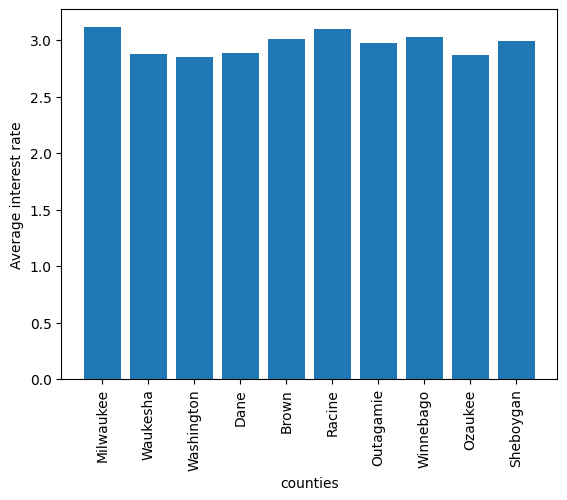

In [25]:
#q7
import matplotlib.pyplot as plt

well = spark.sql("""
SELECT county, AVG(loans.interest_rate) as avg_interest_rate
FROM loans
LEFT JOIN banks ON banks.lei_2020 = loans.lei
LEFT JOIN (
    SELECT DISTINCT NAME as county, CONCAT(LPAD(STATE, 2, '0'), LPAD(COUNTY, 3, '0')) as countycode
    FROM counties ) ON county_code = countycode
WHERE banks.respondent_name =  "Wells Fargo Bank, National Association"
GROUP BY county
ORDER BY COUNT(*) DESC
LIMIT 10
""").toPandas()

plt.bar(well.county, height = well.avg_interest_rate)
plt.xlabel("counties")
plt.ylabel("Average interest rate")
plt.xticks(rotation=90);

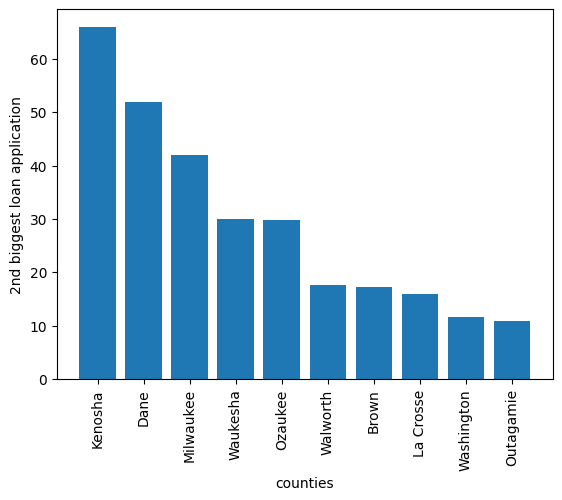

In [26]:
#q8
sec = spark.sql("""
SELECT county, ROUND(loan_amount/1000000, 2) as mil
FROM (
    SELECT county, loan_amount,
        ROW_NUMBER() OVER (PARTITION BY county ORDER BY loan_amount DESC) as rank
    FROM loans
    LEFT JOIN banks ON banks.lei_2020 = loans.lei
    INNER JOIN (
        SELECT DISTINCT NAME as county, CONCAT(LPAD(STATE, 2, '0'), LPAD(COUNTY, 3, '0')) as countycode
        FROM counties
    ) ON county_code = countycode
)
WHERE rank = 2
ORDER BY mil DESC
LIMIT 10
""").toPandas()

plt.bar(sec.county, sec.mil)
plt.xlabel("counties")
plt.ylabel("2nd biggest loan application")
plt.xticks(rotation=90);

# Part 4

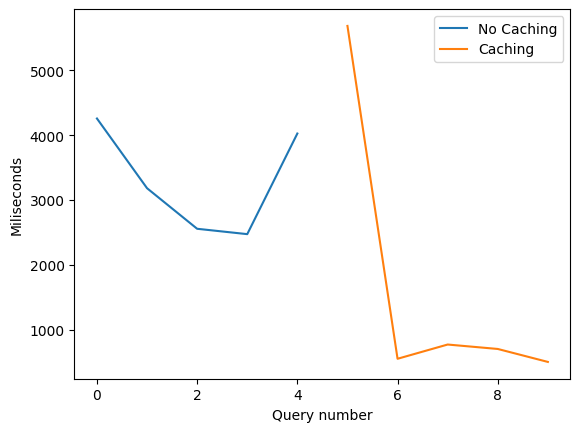

In [27]:
#q9
import time

dff = spark.sql("""
SELECT interest_rate
FROM banks
INNER JOIN loans
ON banks.lei_2020 = loans.lei 
WHERE banks.respondent_name = 'Wells Fargo Bank, National Association'
""")

first=[]
seco=[]
for i in range(10):
    start_time = time.time()
    dff.count()
    end_time = time.time()
    ms = (end_time - start_time) * 1000
    #print(f"Iteration {i+1}: {ms:.2f} ms")
    if i == 4:
        dff.cache()
    if i<=4:
        first.append(ms)
    else:
        seco.append(ms)
        
plt.plot(range(5), first)
plt.plot(range(5,10), seco)
plt.xlabel("Query number")
plt.ylabel("Miliseconds")
plt.legend(["No Caching", "Caching"]);

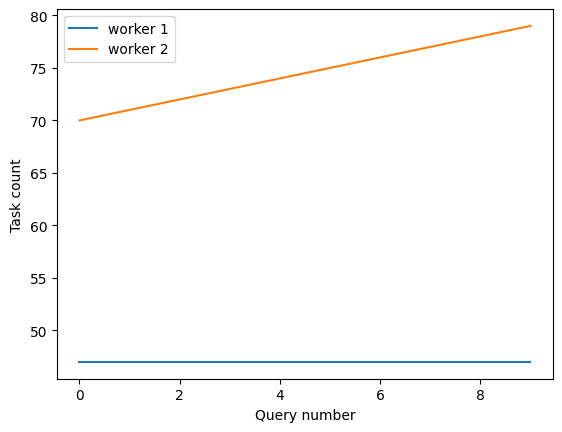

In [30]:
#q10
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
#print(sc.applicationId)

import requests
dff = dff.repartition(1)
dff.cache()

w1=[]
w2=[]
for i in range(10):
    dff.count()
    response = requests.get(f'http://localhost:4040/api/v1/applications/{sc.applicationId}/executors')
    executors = response.json()
    w1.append(executors[1]["completedTasks"])
    w2.append(executors[2]["completedTasks"])
    #print(w1, w2, "\n")
        
plt.plot(range(10), w1)
plt.plot(range(10), w2)
plt.xlabel("Query number")
plt.ylabel("Task count")
plt.legend(["worker 1", "worker 2"]);